In [7]:
import os

# Zeige das aktuelle Arbeitsverzeichnis an
print("Aktuelles Verzeichnis:", os.getcwd())

aktuelles_verzeichnis = os.getcwd()


Aktuelles Verzeichnis: C:\Users\adam8\OneDrive\programmieren\coding\python\Statistik\testat2


In [8]:
os.chdir(aktuelles_verzeichnis)

In [9]:
import pandas as pd
from chardet.universaldetector import UniversalDetector

# Bestimmen Sie das Encoding automatisch
detector = UniversalDetector()
with open("sr_aufg_2_54 (1).txt", 'rb') as file:
    for line in file:
        detector.feed(line)
        if detector.done:
            break
    detector.close()

# Zeige das ermittelte Encoding
print(f"Erkanntes Encoding: {detector.result['encoding']}")


Erkanntes Encoding: ascii


In [10]:
import pandas as pd

df = pd.read_csv(
    'sr_aufg_2_54 (1).txt',    # Pfad zur Datei
    sep=r'\s+',                # Trenner: ein oder mehrere Whitespace-Zeichen
    encoding=detector.result['encoding'],
    header=None,               # keine Kopfzeile in der Datei
    names=['Jahr', 'Bevölkerung']  # Spaltennamen vergeben
)


In [11]:
print(df.head())      # zeigt die ersten 5 Zeilen
print(df.info() )     # zeigt Datentypen und vermisst keine Werte?
#df.describe()  # gibt dir erste Statistik-Kennzahlen


   Jahr Bevölkerung
0  1790    3,929214
1  1800    5,308483
2  1810    7,239881
3  1820    9,638453
4  1830   12,866020
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Jahr         23 non-null     int64 
 1   Bevölkerung  23 non-null     object
dtypes: int64(1), object(1)
memory usage: 500.0+ bytes
None


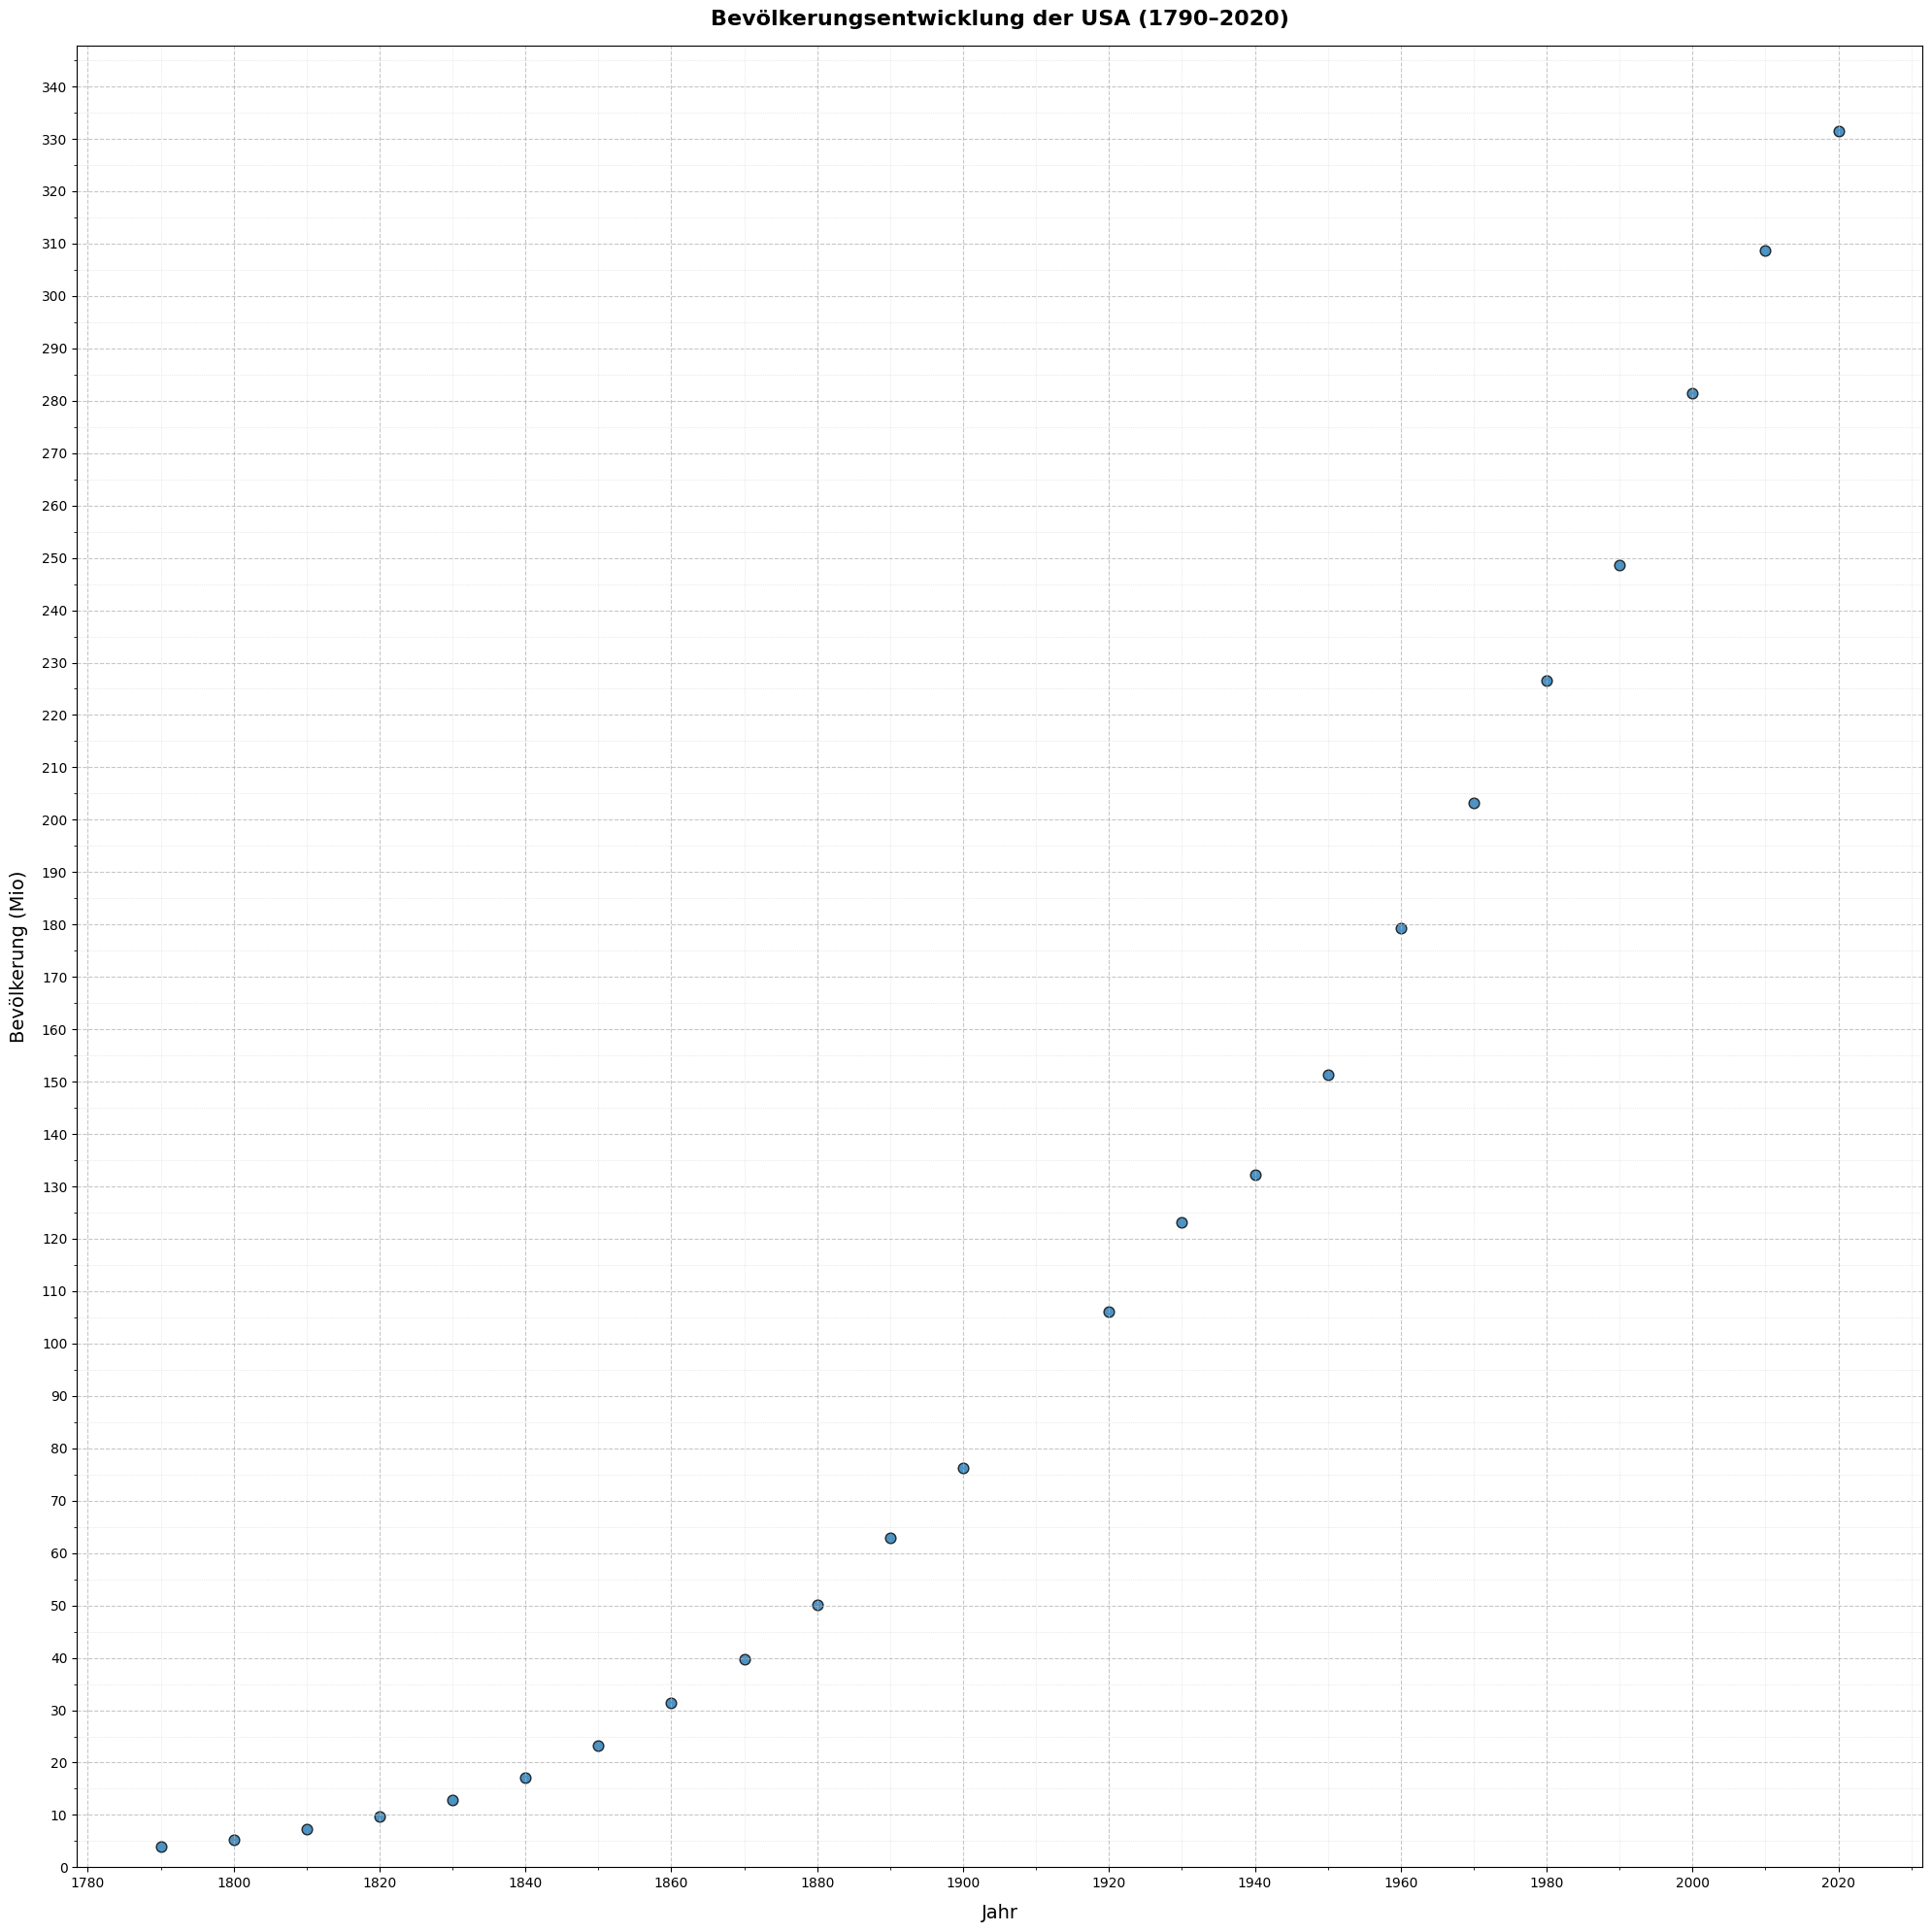

In [27]:
# Endgültiges Streudiagramm im Jupyter Notebook

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Annahme: 'df' existiert bereits mit 'Jahr' und 'Bevölkerung' (als Strings mit Komma)

# 1. Bevölkerung in float umwandeln: Komma → Punkt
df['Bevölkerung'] = (
    df['Bevölkerung']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# 2. Plot erstellen
fig, ax = plt.subplots(figsize=(20, 20))

# 3. Scatter zeichnen
ax.scatter(
    df['Jahr'],
    df['Bevölkerung'],
    marker='o',
    s=60,
    alpha=0.8,
    edgecolor='black'
)

# 4. Achsenbereich festlegen (Y-Achse beginnt bei 0)
ax.set_ylim(bottom=0)

# 5. Ticks setzen
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))  # Hauptticks alle 20 Jahre
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))  # Nebenticks alle 10 Jahre
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))  # Hauptticks alle 10 Mio.
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))   # Nebenticks alle 5 Mio.

# 6. Raster hinzufügen
ax.grid(which='major', linestyle='--', linewidth=0.8, alpha=0.7)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# 7. Titel und Beschriftungen
ax.set_title('Bevölkerungsentwicklung der USA (1790–2020)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Jahr', fontsize=14, labelpad=10)
ax.set_ylabel('Bevölkerung (Mio)', fontsize=14, labelpad=10)

# 8. Layout optimieren und anzeigen
plt.tight_layout()
plt.show()


In [36]:
# === Schritt 1: Daten für die Regression aufbereiten ===
# 1a) Stelle sicher, dass 'Jahr' und 'Bevölkerung' numerisch sind
df['Jahr'] = pd.to_numeric(df['Jahr'], errors='coerce')
df['Bevölkerung'] = (
    df['Bevölkerung']
       .astype(str)
       .str.replace(',', '.', regex=False)
       .astype(float)
)
# 1b) Entferne Zeilen mit fehlenden Werten
df_reg = df.dropna(subset=['Jahr','Bevölkerung']).copy()

# === Schritt 2: Jahreszahlen standardisieren ===
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_reg[['Jahr']].values                 # Form: (n_samples, 1)
X_std = scaler.fit_transform(X)              # Z-Transformation
y = df_reg['Bevölkerung'].values             # Zielvariable

# === Schritt 3: Regressionen schätzen ===
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

results = []

# 3a) Lineares Modell
lin = LinearRegression().fit(X_std, y)
results.append({
    'Modelltyp': 'Lineare Funktion',
    'Intercept': lin.intercept_,
    'Koeffizienten': [lin.coef_[0]],
    'R2': lin.score(X_std, y)
})

# 3b) Polynome 2., 4. und 6. Grades
for deg in [2,4,6]:
    poly = PolynomialFeatures(degree=deg, include_bias=True)
    Xp = poly.fit_transform(X_std)
    reg = LinearRegression().fit(Xp, y)
    results.append({
        'Modelltyp': f'Polynom {deg}. Grades',
        'Intercept': reg.intercept_,
        'Koeffizienten': reg.coef_.tolist(),
        'R2': reg.score(Xp, y)
    })

# 3c) Exponentielles Modell (Log-Linearisierung)
y_log = np.log(y)
exp_reg = LinearRegression().fit(X_std, y_log)
results.append({
    'Modelltyp': 'Exponentielles Modell',
    'Intercept': exp_reg.intercept_,
    'Koeffizienten': [exp_reg.coef_[0]],
    'R2': exp_reg.score(X_std, y_log)
})

# === Schritt 4: Ergebnisse in Tabelle ausgeben ===
import pandas as pd
table = pd.DataFrame(results)

# Runden für Übersichtlichkeit
table['Intercept']     = table['Intercept'].round(4)
table['Koeffizienten'] = table['Koeffizienten'].apply(lambda lst: [round(v,4) for v in lst])
table['R2']            = table['R2'].round(4)

# Tabelle anzeigen
#display(table)
# ——— ab hier in dieselbe Zelle einfügen ———

# 1) Achsenabschnitt und Koeffizienten in einer Spalte zusammenfassen
table['Koeffizienten mit b'] = table.apply(
    lambda r: f"{r['Intercept']:.8f}, " + ", ".join(f"{c:.8f}" for c in r['Koeffizienten']),
    axis=1
)

# 2) Spalten auswählen und umbenennen
table_clean = table[[
    'Modelltyp',
    'Koeffizienten mit b',
    'R2'
]].rename(columns={
    'Modelltyp': 'Regressionstyp',
    'R2':        'Bestimmtheitsmaß R²'
})

# 3) Als Markdown-Tabelle anzeigen
from IPython.display import Markdown, display
display(Markdown(table_clean.to_markdown(index=False)))


| Regressionstyp        | Koeffizienten mit b                                                                                  |   Bestimmtheitsmaß R² |
|:----------------------|:-----------------------------------------------------------------------------------------------------|----------------------:|
| Lineare Funktion      | 114.43940000, 100.79080000                                                                           |                0.9247 |
| Polynom 2. Grades     | 80.74600000, 0.00000000, 100.48050000, 33.69340000                                                   |                0.9993 |
| Polynom 4. Grades     | 80.35560000, 0.00000000, 98.38060000, 34.92580000, 1.22060000, -0.49550000                           |                0.9994 |
| Polynom 6. Grades     | 82.17840000, 0.00000000, 95.55550000, 22.67200000, 5.86690000, 12.23130000, -1.46340000, -3.26280000 |                0.9996 |
| Exponentielles Modell | 4.05840000, 1.34730000                                                                               |                0.9616 |